# 02. PyTorch Classification Exercises

In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "mps" if  torch.backends.mps.is_built()\
    else "gpu" if torch.cuda.is_available() else "cpu"
print(device)

# Setup random seed
RANDOM_SEED = 42

mps


## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors. 
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.07, random_state=RANDOM_SEED)
X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [3]:
# Turn data into a DataFrame
import pandas as pd

data = pd.DataFrame({"X1": X[:,0],
                     "X2": X[:,1],
                     "label": y})
data.head(10)

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
5,0.599064,-0.289773,1
6,0.290090,-0.204688,1
7,-0.038269,0.459429,1
8,1.613771,-0.293970,1
9,0.693337,0.827819,0


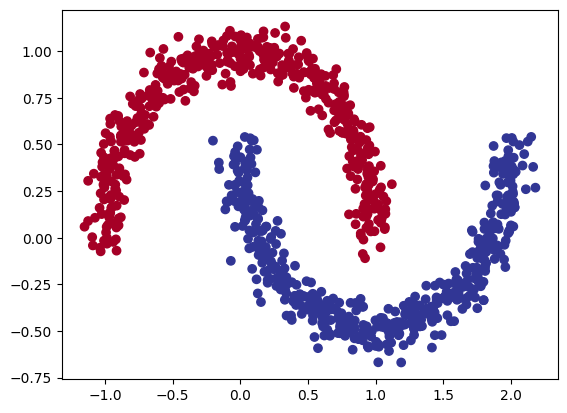

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

In [5]:
X.shape, y.shape, type(X)

((1000, 2), (1000,), numpy.ndarray)

In [6]:
# Turn data into tensors of dtype float
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=RANDOM_SEED)

In [7]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [8]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Instantiate the model
model_0 = MoonModelV0()
model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [9]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [10]:
# What's coming out of our model?
y_logits = model_0(X_train[:10]).squeeze()
# logits (raw outputs of model)
print("Logits:", y_logits)

# Prediction probabilities
pred_probs = torch.sigmoid(y_logits)
print("Pred probs:", pred_probs)

# Prediction labels
pred_labels = torch.round(pred_probs)
print("Pred labels:", pred_labels)


Logits: tensor([0.1791, 0.1758, 0.1651, 0.1683, 0.1434, 0.1678, 0.1239, 0.1590, 0.1828,
        0.1673], grad_fn=<SqueezeBackward0>)
Pred probs: tensor([0.5447, 0.5438, 0.5412, 0.5420, 0.5358, 0.5419, 0.5309, 0.5397, 0.5456,
        0.5417], grad_fn=<SigmoidBackward0>)
Pred labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<RoundBackward0>)


In [11]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2)
acc_fn

MulticlassAccuracy()

In [12]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (logits output)
    y_logits = model_0(X_train).squeeze()
    
    # Turn logits into prediction probabilities
    pred_probs = torch.sigmoid(y_logits)

    # Turn prediction probabilities into prediction labels
    pred_labels = torch.round(pred_probs)

    # 2. Calculaute the loss
    loss = loss_fn(y_logits, y_train)
    # Calculate the accuracy
    acc = acc_fn(pred_labels, y_train.int())

    # 3. Zero the gradients
    optimizer.zero_grad()
    # 4. Loss backward (perform backpropagation)
    loss.backward()
    # 5. Step the optimizer (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval() 
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        test_logits = model_0(X_test).squeeze()
        # Turn the test logits into prediction labels
        test_labels = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_labels, y_test.int())

    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | train loss: {loss:.4f} | test loss: {test_loss:.4f} | test acc: {test_acc:.2f}%")

Epoch: 0 | train loss: 0.7071 | test loss: 0.7068 | test acc: 0.50%
Epoch: 100 | train loss: 0.4834 | test loss: 0.4909 | test acc: 0.81%
Epoch: 200 | train loss: 0.2584 | test loss: 0.2601 | test acc: 0.89%
Epoch: 300 | train loss: 0.2443 | test loss: 0.2399 | test acc: 0.89%
Epoch: 400 | train loss: 0.2378 | test loss: 0.2328 | test acc: 0.90%
Epoch: 500 | train loss: 0.2285 | test loss: 0.2237 | test acc: 0.90%
Epoch: 600 | train loss: 0.2141 | test loss: 0.2097 | test acc: 0.90%
Epoch: 700 | train loss: 0.1924 | test loss: 0.1887 | test acc: 0.90%
Epoch: 800 | train loss: 0.1624 | test loss: 0.1588 | test acc: 0.92%
Epoch: 900 | train loss: 0.1256 | test loss: 0.1211 | test acc: 0.95%


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [13]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

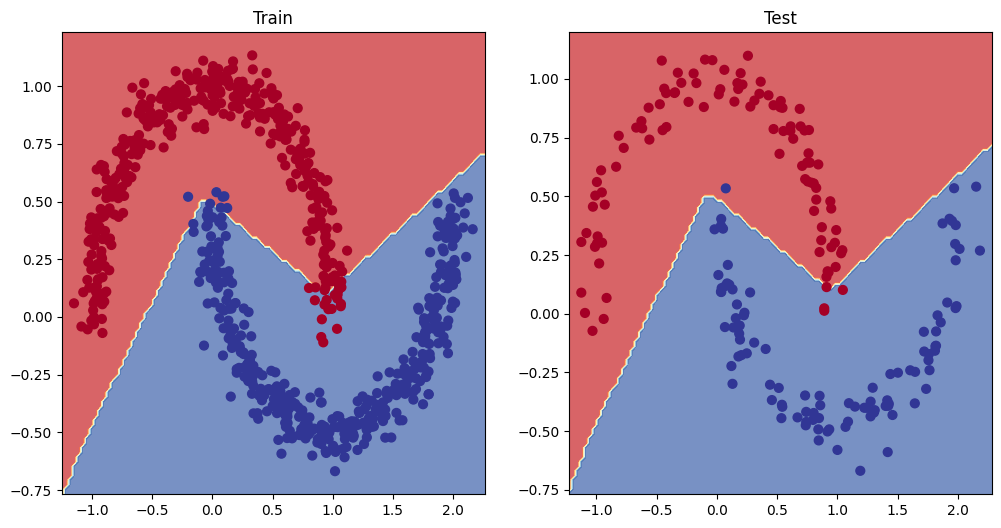

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

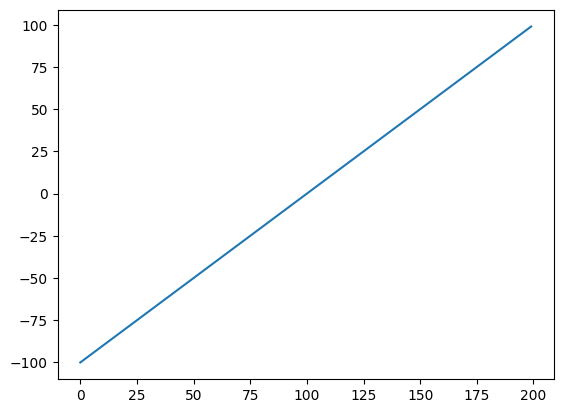

In [16]:
# Create a straight line tensor
str_line = torch.arange(start=-100, end=100, step=1)
plt.plot(str_line)

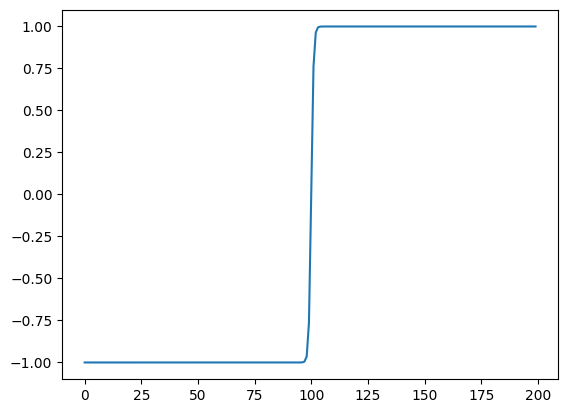

In [17]:
# Test torch.tanh() on the tensor and plot it
line_tanh = torch.tanh(str_line)

plt.plot(line_tanh)

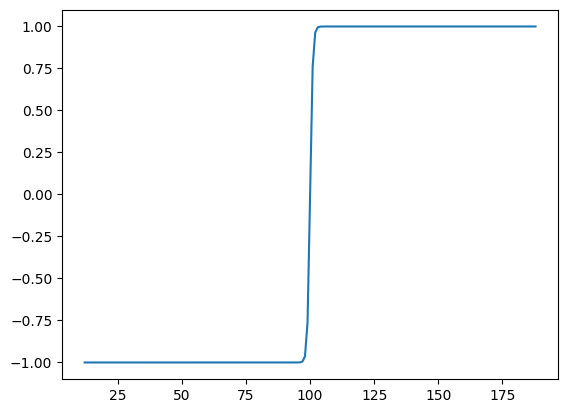

In [18]:
# Replicate torch.tanh() and plot it
def my_tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))


plt.plot(my_tanh(str_line))


## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

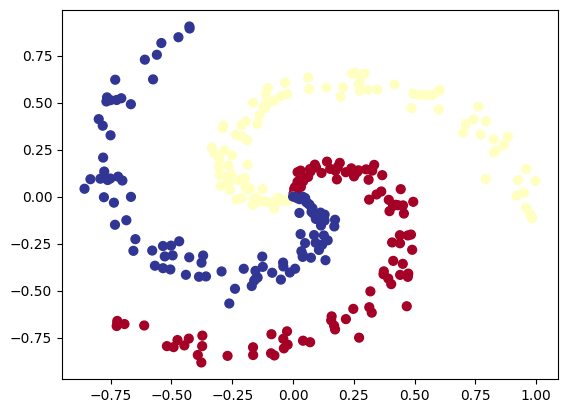

In [18]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [19]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split


In [20]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
# acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
# acc_fn

In [21]:
# Prepare device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module



# Instantiate model and send it to device


In [22]:
# Setup data to be device agnostic


# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
## Your code here ##

print("Pred probs:")
## Your code here ##

print("Pred labels:")
## Your code here ##

Logits:
Pred probs:
Pred labels:


In [23]:
# Setup loss function and optimizer
# loss_fn =
# optimizer = 

In [24]:
# Build a training loop for the model

# Loop over data


  ## Training
  
  # 1. Forward pass
  

  # 2. Calculate the loss
  
  
  # 3. Optimizer zero grad
  

  # 4. Loss backward
  

  # 5. Optimizer step
  

  ## Testing
  

    # 1. Forward pass
    
    # 2. Caculate loss and acc
    
  # Print out what's happening every 100 epochs
  

In [25]:
# Plot decision boundaries for training and test sets
